In [40]:
sys.path.append("..")
import os
import utils
import plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils
import pandas as pd
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.ticker import PercentFormatter
import glob

## General functions

In [41]:
def prepare_regional_data(data):
    m,n,r = data.shape
    out_arr = np.column_stack((np.repeat(np.arange(m),n),data.reshape(m*n,-1)))
    out_df = pd.DataFrame(out_arr)
    out_df['week'] = out_df.index % data.shape[1]
    out_df = out_df.rename(columns={0:'simulation'})
    out_df['simulation'] = out_df['simulation'].astype(int)
    out_df.set_index(['simulation', 'week'], inplace=True)
    return out_df

In [42]:
def generate_accumulated_age_infection_data():
    path = '../data/age_infections'
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    master_df =  pd.DataFrame(columns = ['week', 'Aldersgrupper (per 10 år)', 'Kvinner', 'Menn'])
    week = 1
    for f in csv_files:
        df = pd.read_csv(f)
        df['week'] = week
        week += 1
        master_df =master_df.append(df)
    master_df['infected'] = master_df['Kvinner'] + master_df['Menn']
    master_df['age_group'] = master_df['Aldersgrupper (per 10 år)']
    master_df = master_df[['week', 'age_group', 'infected']]
    df_age = master_df.set_index('age_group').pivot(columns="week", values='infected')
    df_age.to_csv('../data/infected_per_age_group_per_week_untreated.csv',index=False)

# Spatial Plotting for different strategies

## Prepare data

In [43]:
# Read data and generate parameters
paths = utils.create_named_tuple('paths', 'filepaths.txt')
config = utils.create_named_tuple('config', paths.config)
age_labels = utils.generate_labels_from_bins(config.age_bins)
population = utils.generate_custom_population(config.age_bins, age_labels)

In [44]:
# generate geodatefram for plotting
gdf = utils.generate_geopandas(population, paths.municipalities_geo)

In [45]:
# Infection policy
(age_labels,
            vaccines_available, 
            flow_scale,
            contact_weights,
            S_regions_inf,
            I_regions_inf,
            new_infected_regions_inf,
            new_deaths_regions_inf,
            V_regions_inf,
            S_age_groups,
            I_age_groups,
            new_infected_age_groups,
            new_deaths_age_groups,
            vaccinated_age_groups,
            dates) = utils.read_csv('results/5_simulations_infection_based_2021_06_02_13_44_25')
X = np.insert(np.diff(V_regions_inf, axis=1), 0, 0, axis=1) # Need to this on vaccines since the first week is deleted when taking the difference of V for each week
df_x_regions_inf = prepare_regional_data(X)

Reading results ..
100%|██████████| 5/5 [00:00<00:00, 92.58it/s]


In [46]:
# Susceptible policy
(age_labels,
            vaccines_available, 
            flow_scale,
            contact_weights,
            S_regions_sus,
            I_regions_sus,
            new_infected_regions_sus,
            new_deaths_regions_sus,
            V_regions_sus,
            S_age_groups,
            I_age_groups,
            new_infected_age_groups,
            new_deaths_age_groups,
            vaccinated_age_groups,
            dates) = utils.read_csv('results/5_simulations_susceptible_based_2021_06_02_13_42_31')
X = np.insert(np.diff(V_regions_sus, axis=1), 0, 0, axis=1)
df_x_regions_sus = prepare_regional_data(X)

Reading results ..
100%|██████████| 5/5 [00:00<00:00, 70.39it/s]


In [47]:
# FHI policy
(age_labels,
            vaccines_available, 
            flow_scale,
            contact_weights,
            S_regions_fhi,
            I_regions_fhi,
            new_infected_regions_fhi,
            new_deaths_regions_fhi,
            V_regions_fhi,
            S_age_groups,
            I_age_groups,
            new_infected_age_groups,
            new_deaths_age_groups,
            vaccinated_age_groups,
            dates) = utils.read_csv('results/500_simulations_fhi_policy_2021_06_02_12_35_53')
X = np.insert(np.diff(V_regions_sus, axis=1), 0, 0, axis=1)
df_x_regions_sus = prepare_regional_data(X)

Reading results ..
100%|██████████| 500/500 [00:05<00:00, 87.88it/s]


In [48]:
I_regions_fhi_cum =I_regions_fhi.cumsum(axis=1)
I_regions_fhi_cum = prepare_regional_data(I_regions_fhi_cum)

In [49]:
# load all data in one dictionary
data = {'Infected-policy': df_x_regions_inf, 'Susceptible-policy': df_x_regions_sus, 'Cumulative-Infected-FHI': I_regions_fhi_cum}

## Plot

In [50]:
plt.style.use('seaborn-ticks')
simulations = [0] # simulation starts at 0
weeks = [45, 70, 72] # weeks starts at 1
policies = list(data.keys())
max_images_on_one_row = 2
nrows=1
ncols=3

for sim in simulations:
    for week in weeks:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*ncols,12*nrows), sharex=True)
        col = 0 
        for i, value in enumerate(policies):
            x = data[value].loc[(sim,week)]
            x.index -= 1
            gdf[value] = x
            ax = axs[col]
            if value == 'Symptomatic-Infected':
                gdf.plot(ax=ax, column=value, facecolor='white', edgecolor='black', alpha=1, linewidth=0.1, zorder=2, cmap='Reds', legend=True, vmin=0,vmax=50)
            else:
                gdf[value+'_percentage'] = gdf[value]/gdf['population']
                gdf.plot(ax=ax, column=value+'_percentage', facecolor='white', edgecolor='black', alpha=1, linewidth=0.1, zorder=2, cmap='Blues', legend=True, vmin=0,vmax=0.2)
            ax.axis('off')
            col += 1
        plt.draw()
        plt.savefig(f"../plots/computational_study/regional_development/sim_{sim}_week_{week}.jpg", dpi=fig.dpi, bbox_inches = 'tight')
        plt.close()

# Plot objective comparison

## Prepare Data

In [51]:
# Load data
df = pd.read_csv('../data/waves/world_daily_cases.csv')
df = df[df.country == "Norway"].fillna(0)

In [52]:
# Calculate percentiles
percentile_limit=90

new_deaths_all_age_groups = np.sum(new_deaths_age_groups, axis=2)
new_infected_all_age_groups =  np.sum(new_infected_age_groups, axis=2)

deaths_cumulative = new_deaths_all_age_groups.cumsum(axis=1)
deaths_mean = new_deaths_all_age_groups.mean(axis=0)
deaths_mean_cumulative = deaths_cumulative.mean(axis=0)
u_percentile_deaths = np.percentile(new_deaths_all_age_groups, percentile_limit, axis=0)
l_percentile_deaths = np.percentile(new_deaths_all_age_groups, 100-percentile_limit, axis=0)
u_percentile_deaths_cum = np.percentile(deaths_cumulative, percentile_limit, axis=0)
l_percentile_deaths_cum = np.percentile(deaths_cumulative, 100-percentile_limit, axis=0)

infected_cumulative = new_infected_all_age_groups.cumsum(axis=1)
infected_mean = new_infected_all_age_groups.mean(axis=0)
infected_mean_cumulative = infected_cumulative.mean(axis=0)
u_percentile_infected = np.percentile(new_infected_all_age_groups, percentile_limit, axis=0)
l_percentile_infected = np.percentile(new_infected_all_age_groups, 100-percentile_limit, axis=0)
u_percentile_infected_cum = np.percentile(infected_cumulative, percentile_limit, axis=0)
l_percentile_infected_cum = np.percentile(infected_cumulative, 100-percentile_limit, axis=0)

## Plot cases - average across simulations

In [53]:
# Define colours
colors = sns.color_palette('Set2')
color_1 = 1
color_2 = 2

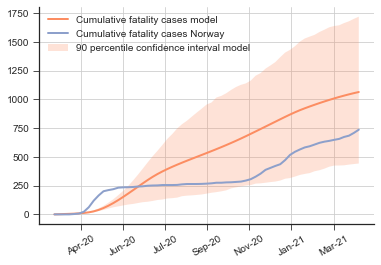

In [54]:
plt.style.use('seaborn-ticks')
restrict_to_real_data_length = True
max_weeks_real_data = 63
fig, ax = plt.subplots(1)

if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], deaths_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative fatality cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color=colors[color_2])
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_deaths_cum[:max_weeks_real_data], l_percentile_deaths_cum[:max_weeks_real_data], facecolor=colors[color_1], alpha=0.25, label='90 percentile confidence interval model')

else:
    ax.plot(dates[:-1], deaths_mean_cumulative[:-1], lw=2, label='Cumulative fatality cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color=colors[color_2])
    ax.fill_between(dates, u_percentile_deaths_cum, l_percentile_deaths_cum, facecolor=colors[color_1], alpha=0.25, label='90 percentile confidence interval model')

ax.legend(loc='upper left')
# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/norwegian_numbers_comparison_objective/mean_match_deaths.png", bbox_inches='tight', dpi=150)

## Plot deaths - average across simulations

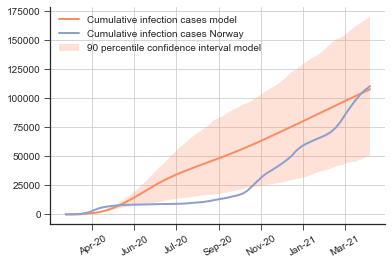

In [55]:
plt.style.use('seaborn-ticks')
restrict_to_real_data_length = True
max_weeks_real_data = 63
sim = 1 

fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], infected_mean_cumulative[:max_weeks_real_data], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.fill_between(dates[:max_weeks_real_data], u_percentile_infected_cum[:max_weeks_real_data], l_percentile_infected_cum[:max_weeks_real_data], facecolor=colors[1], alpha=0.25, label='90 percentile confidence interval model')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])
else:
    ax.plot(dates[:-1], infected_mean_cumulative[:-1], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.fill_between(dates, u_percentile_infected_cum, l_percentile_infected_cum, facecolor=colors[color_1], alpha=0.25, label='90 percentile confidence interval model')
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])

#ax.set_title(r'Cumulative and new infected per week')
ax.legend(loc='upper left')
# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/norwegian_numbers_comparison_objective/mean_match_cases.png", bbox_inches='tight', dpi=150)

## Plot deaths - single simulation

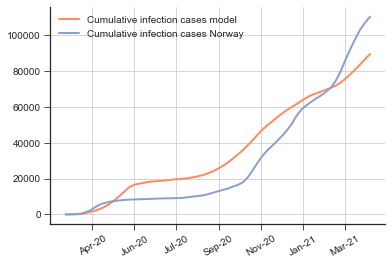

In [56]:
plt.style.use('seaborn-ticks')
restrict_to_real_data_length = True
max_weeks_real_data = 63
sim = 2  # Good case:2, Bad case: 0

fig, ax = plt.subplots(1)
#ax.plot(dates, deaths_mean, lw=2, label='Deaths model', color='blue')
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], infected_cumulative[sim][:max_weeks_real_data], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])
else:
    ax.plot(dates[:-1], infected_cumulative[sim][:-1], lw=2, label='Cumulative infection cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_cases.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative infection cases Norway', color=colors[color_2])

#ax.set_title(r'Cumulative and new infected per week')
ax.legend(loc='upper left')
# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/norwegian_numbers_comparison_objective/good_match_cases.png", bbox_inches='tight', dpi=150)

## Plot cases - single simulation

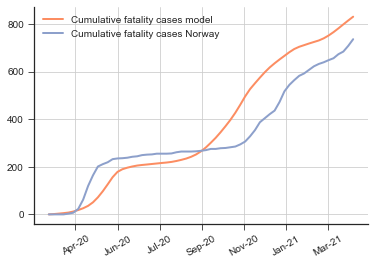

In [57]:
plt.style.use('seaborn-ticks')
restrict_to_real_data_length = True
max_weeks_real_data = 63
simulation = 2

fig, ax = plt.subplots(1)
if restrict_to_real_data_length:
    ax.plot(dates[:max_weeks_real_data], deaths_cumulative[simulation][:max_weeks_real_data], lw=2, label='Cumulative fatality cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color=colors[color_2])

else:
    ax.plot(dates[:-1], deaths_cumulative[simulation][:-1], lw=2, label='Cumulative fatality cases model', color=colors[color_1])
    ax.plot(dates[:max_weeks_real_data], df.cumulative_total_deaths.to_numpy(dtype=int)[:max_weeks_real_data*7:7], lw=2, label='Cumulative fatality cases Norway', color=colors[color_2])

ax.legend(loc='upper left')
# Format the date into months & days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
# Change the tick interval
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
# Puts x-axis labels on an angle
plt.gca().xaxis.set_tick_params(rotation =30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
fig.savefig("../plots/computational_study/norwegian_numbers_comparison_objective/good_match_deaths.png", bbox_inches='tight', dpi=150)

# Plot Regional Comparison

## Clean data

In [58]:
# read data 
df = pd.read_csv('../data/infected_municipalities_covidnorway.csv')

# aggregate data across bydeler
df_municipalities = df.groupby(['date', 'kommune_no']).agg('sum')
df_municipalities.reset_index(inplace=True)

# Remove unknown municipalities
f1 = df_municipalities['kommune_no'] != 9998 
f2 = df_municipalities['kommune_no'] != 9999
df_municipalities = df_municipalities[f1 & f2]

# transform to weekly data 
df_municipalities['date'] = pd.to_datetime(df_municipalities['date'])
df_municipalities['week'] = df_municipalities['date'].dt.isocalendar().week
df_municipalities['year'] = df_municipalities['date'].dt.isocalendar().year
resample_dict ={'cases':'last', 'date':'last'}
df_municipalities = df_municipalities.groupby(['year', 'week', 'kommune_no']).agg(resample_dict)
df_municipalities.reset_index(inplace=True)
df_municipalities['week'] = np.where(df_municipalities['year'] > 2020, df_municipalities['week'] + 53, df_municipalities['week'])
df_municipalities = df_municipalities[['week', 'cases', 'kommune_no']]

# transform data
df_municipalities = df_municipalities.set_index('week').pivot(columns="kommune_no", values='cases')
mapper = {df_municipalities.columns[i]: i+1 for i in range(len(df_municipalities.columns))}
df_municipalities = df_municipalities.rename(mapper, axis=1).reset_index()
df_municipalities = df_municipalities.set_index(['week']) 
df_municipalities.index = df_municipalities.index - 8 # to get same start week as simulation (simulation starts in week 9, data starts in week 13.
df_municipalities


kommune_no,1,2,3,4,5,6,7,8,9,10,...,347,348,349,350,351,352,353,354,355,356
week,,,,,,,,,,,,,,,,,,,,,
5,1122,9,98,47,39,2,0,0,5,5,...,2,3,1,0,0,0,0,1,0,4
6,1582,14,124,49,44,3,0,0,6,6,...,2,4,1,0,0,0,1,1,0,4
7,1893,14,125,49,46,3,0,0,6,6,...,2,4,1,0,0,0,1,1,0,4
8,2132,14,129,50,46,5,1,0,6,6,...,2,4,1,0,0,0,1,1,0,4
9,2307,14,132,51,47,5,1,0,7,6,...,2,4,1,0,0,0,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,34213,130,2340,811,835,13,12,17,139,225,...,4,31,2,2,1,1,5,1,11,28
64,34796,131,2409,811,862,13,12,17,141,230,...,4,32,2,2,1,1,5,1,11,28
65,35283,132,2478,831,873,14,12,17,143,232,...,5,32,2,2,1,1,5,2,11,28


In [59]:
# load all data in one dictionary
data['Norway'] = df_municipalities

In [70]:
# Define colourmap

limits = [100, 200, 300, 500, 1000]

reds = sns.color_palette('Reds')
red0 = np.append(np.array(reds[0]), 1)
red1 = np.append(np.array(reds[1]), 1)
red2 = np.append(np.array(reds[2]), 1)
red3 = np.append(np.array(reds[3]), 1)
red4 = np.append(np.array(reds[4]), 1)
red5 = np.append(np.array(reds[5]), 1)
white = np.ones(shape=red0.shape) 

min_value = 0
max_value = limits[-1]
mapping = np.linspace(min_value, max_value, 256)
newcolors = np.empty((256, 4))
newcolors[mapping < limits[0]] = white
newcolors[mapping > limits[0]] = red1
newcolors[mapping > limits[1]] = red2
newcolors[mapping > limits[2]] = red3
newcolors[mapping > limits[3]] = red4
newcolors[mapping > limits[4]] = red5

my_colormap = ListedColormap(newcolors)

In [61]:
date = dates[5]
date

Timestamp('2020-03-30 00:00:00')

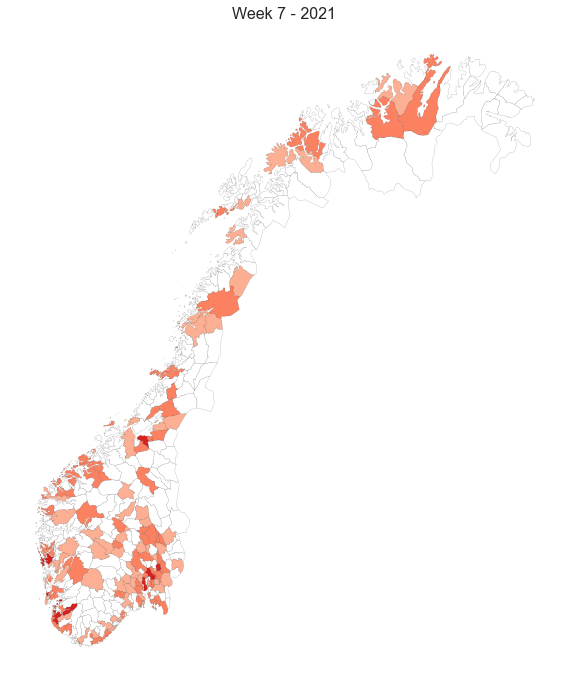

In [88]:
# Plot policies
simulations = 2 
week = 60  # 5 <= x <= 67 #  starting from simulation start date
policy = 'Cumulative-Infected-FHI' # 'Cumulative-Infected-FHI', 'Norway'
max_cols = 3

fig, ax = plt.subplots(1, figsize=(12,12))
I = data[policy].loc[(sim,week)] if policy != 'Norway' else data[policy].loc[week]
I.index -= 1
gdf[week] = I
gdf[week] =  gdf[week].apply(
lambda x: 0 if x < limits[0] else 
(limits[0] if x < limits[1] else 
(limits[1] if x < limits[2] else 
(limits[2] if x < limits[3] else 
(limits[3] if x < limits[4] else 
limits[4] )))))

gdf.plot(ax=ax, column=week, facecolor='white', edgecolor='black', alpha=1, linewidth=0.1, zorder=2, cmap=my_colormap, legend=False, vmin=0, vmax=limits[-1])
ax.axis('off')
year = 2020 if week <53 else 2021
ax.set_title(f'Week {week %53} - {year}', size=16)
date = dates[week] 
plt.draw()
plt.savefig(f"../plots/computational_study/norwegian_numbers_comparison_regional/{policy}_week_{week}.jpg", dpi=fig.dpi, bbox_inches = 'tight')

# Plot age comparison

In [63]:
# FHI policy
(age_labels,
            vaccines_available, 
            flow_scale,
            contact_weights,
            S_regions_fhi,
            I_regions_fhi,
            new_infected_regions_fhi,
            new_deaths_regions_fhi,
            V_regions_fhi,
            S_age_groups,
            I_age_groups,
            new_infected_age_groups,
            new_deaths_age_groups,
            vaccinated_age_groups,
            dates) = utils.read_csv('results/500_simulations_fhi_policy_2021_06_02_12_35_53')
X = np.insert(np.diff(V_regions_sus, axis=1), 0, 0, axis=1)
df_x_regions_sus = prepare_regional_data(X)

Reading results ..
100%|██████████| 500/500 [00:06<00:00, 73.95it/s]


In [64]:
I_mean_norway = pd.read_csv('../data/infected_per_age_group_per_week.csv').to_numpy().T
I_mean_norway = I_mean_norway[1:]*100
I_mean_norway.shape

(67, 7)

In [65]:
I_mean = np.mean(I_age_groups, axis=0) 
normed_I_mean= normalize(I_mean, axis=1, norm='l1') * 100
normed_I_mean.shape

(75, 7)

In [89]:
# Norway data
def plot_age_distributions(data, start_week, max_weeks_real_data, dates, fpath):
    plt.style.use('seaborn-ticks')
    restrict_to_real_data_length = True
    fig, ax = plt.subplots(1, figsize=(8,6))

    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,0], label='0-17')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,1], label='18-44')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,2], label='45-54')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,3], label='55-64')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,4], label='65-74')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,5], label='75-84')
    plt.plot(dates[start_week-1:max_weeks_real_data], data[start_week-1:max_weeks_real_data,6], label='85+'  )

    ax.legend(loc='upper left')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) 
    plt.gca().xaxis.set_tick_params(rotation =30)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid()
    ax.legend(loc='upper right')
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.ylim((0,70))
    plt.savefig(fpath, dpi=fig.dpi, bbox_inches = 'tight')

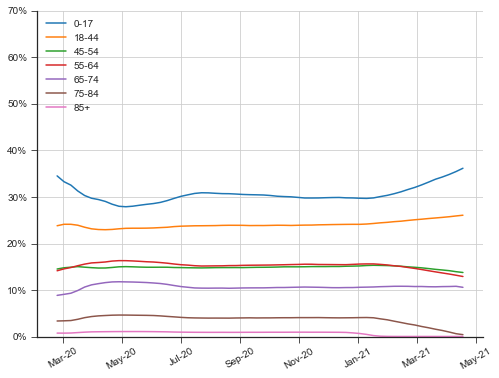

In [67]:
start_week = 5 # weeks from 24.2 
max_weeks_real_data = 64
fpath = '../plots/computational_study/norwegian_numbers_comparison_age/model_estimates.jpg'
plot_age_distributions(normed_I_mean, start_week, max_weeks_real_data, dates, fpath)

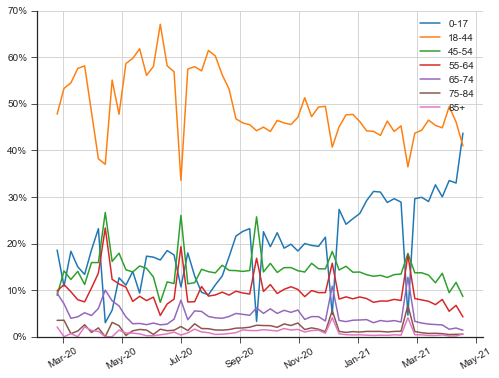

In [90]:
start_week = 5 # weeks from 24.2 
max_weeks_real_data = 64
fpath = '../plots/computational_study/norwegian_numbers_comparison_age/norway_numbers.jpg'
plot_age_distributions(I_mean_norway, start_week, max_weeks_real_data, dates, fpath)